In [1]:
import os
import matplotlib
import fiona

import pandas as pd
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tqdm import tqdm
from matplotlib import gridspec
from datetime import datetime, timedelta
from rasterio import features, mask
from IPython.display import HTML
from dateutil.relativedelta import relativedelta
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

matplotlib.rcParams['animation.embed_limit'] = 2**128

In [2]:
# Find SWE files
data_dir = "../data/LRM_SWE_monthly"
files = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if x.endswith(".tif")]
files.sort()

# Read CVWS shapefile
with fiona.open("../shape/cvws.shp", "r") as shapefile:
    cvws_geom = [feature["geometry"] for feature in shapefile]

In [3]:
# Read the files, mask nans, clip to CVWS, extract dates
imdict = {}

for i in tqdm(files[:]):
    date = datetime.strptime(i[-12:-4],'%Y%m%d')+ timedelta(days=-1) # Get the date 
    datestr = date.strftime('%Y%m%d') # Format date
    src = rio.open(i) # Read file
    src2 = rio.mask.mask(src, cvws_geom, crop=True) # Clip to CVWS 
    arr = src2[0] # read as array
    arr = arr.reshape(arr.shape[1], arr.shape[2]) # Reshape bc rasterio has a different dim ordering 
    arr[arr < 0 ] = np.nan # Mask nodata vals 
    imdict[datestr] = arr

100%|██████████| 116/116 [01:12<00:00,  1.60it/s]


In [4]:
# Fill in the dates with no SWE with nans 
dt_idx = pd.date_range(list(imdict.keys())[0], list(imdict.keys())[-1], freq = "M")

all_dates = {}

for i in dt_idx:
    date = i.strftime("%Y%m%d") 
    
    if date in imdict.keys():
        im = imdict[date]
    else:
        im = np.zeros_like(list(imdict.values())[0])
        im[im==0] = np.nan
    all_dates[date] = im

In [5]:
# Stack all dates to 3D array
cvws_swe = np.dstack(list(all_dates.values()))

# Compute monthly sums
swesums = []
for i in range(cvws_swe.shape[2]):
    swesums.append(np.nansum(cvws_swe[:,:,i] *500**2 * 1e-9)) # mult by 2500m pixel area, convert m^3 to km^3

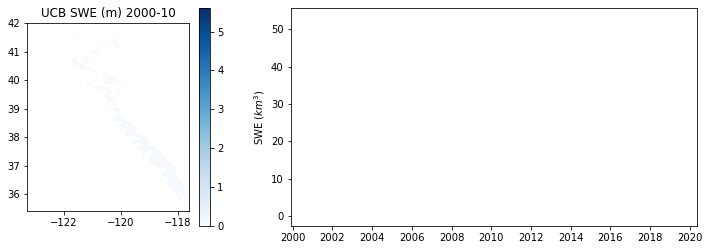

In [6]:
# Make animation

# Setup BBox
lon_top_left, lat_bottom_left, lon_top_right, lat_top_left = src.bounds
extent=[lon_top_left,lon_top_right,lat_bottom_left,lat_top_left]

# Setup figure
fig, ax = plt.subplots(figsize=(12,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 

# Plot basemap at t0
ax0 = plt.subplot(gs[0])
cax = plt.imshow(cvws_swe[:,:,0], cmap = 'Blues', extent = extent, vmin = 0, vmax = np.nanmax(cvws_swe))
plt.colorbar()

# Plot timeseries at t0
ax1 = plt.subplot(gs[1])
line, = ax1.plot(dt_idx,np.array(swesums),color='k')
ax1.set_ylabel("SWE $(km^3)$")

# Function to animate 
def animate(frame):
    cax.set_array(cvws_swe[:,:,frame]) 
    ax0.set_title("UCB SWE (m) " + str(dt_idx[frame])[:-12])
    line.set_data(dt_idx[:frame],swesums[:frame])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames= cvws_swe.shape[2],       # Could also be iterable or list
    interval=200, # ms between frames
    repeat = True
)

HTML(ani.to_jshtml())

In [7]:
swedf = pd.DataFrame(swesums, index = dt_idx)
swedf.columns = ["SWE_km3"]
# swedf.to_csv("../data/UCB_LRM_SWE.csv")

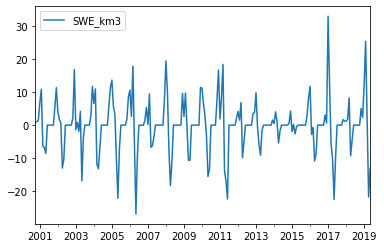

In [8]:
swedf.diff().plot()

In [9]:
# Make a nicer figure and animation with basemap 

<ipython-input-10-206b2a06bd17>:30: RuntimeWarning: Mean of empty slice
  mean_swe = np.flipud(np.nanmean(cvws_swe, axis = 2))


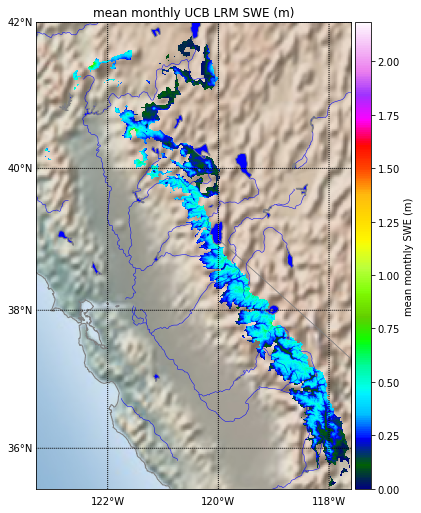

In [10]:
# Setup fig 
f, ax1 = plt.subplots(1,1,figsize=(6,9))

# get bbox of swe data
imextent = src.bounds
lllon, lllat = imextent[0], imextent[1]
urlon, urlat = imextent[2], imextent[3]

# Initialize the basemap
m = Basemap(ax = ax1,projection='merc', ellps='WGS84',resolution='f', 
            llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat) # CVWS bbox for basemap

# Add stuff to basemap 
# m.etopo(zorder = 0)
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Plot array 
mean_swe = np.flipud(np.nanmean(cvws_swe, axis = 2))
im = m.imshow(mean_swe, cmap='gist_ncar', vmin = 0, vmax = np.nanmax(mean_swe))

# Set location of the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(mappable=im, cax=cax, label='mean monthly SWE (m)')

ax1.set_title('mean monthly UCB LRM SWE (m)')
plt.show()

In [ ]:
# Make animation

# Setup fig 
f, ax = plt.subplots(figsize=(12,4))

# get bbox of swe data
imextent = src.bounds
lllon, lllat = imextent[0], imextent[1]
urlon, urlat = imextent[2], imextent[3]

# Select the first fig on left 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
ax0 = plt.subplot(gs[0])

# Initialize the basemap
m = Basemap(ax = ax0,projection='merc', ellps='WGS84',resolution='i', 
            llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat) # CVWS bbox for basemap

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawrivers(color = "blue")
m.fillcontinents(color='none',lake_color='blue')

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Plot array 
im = m.imshow(np.flipud(cvws_swe[:,:,0]), cmap='gist_ncar', vmin = 0, vmax = np.nanmax(mean_swe))

# Set location of the colorbar
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(mappable=im, cax=cax)

######## Time Series Plot
ax1 = plt.subplot(gs[1])
line, = ax1.plot(dt_idx,swesums,color='k')
ax1.set_ylabel("SWE $(km^3)$")

###### Animation Functions
def animate(frame):
    im.set_array(np.array(np.flipud(cvws_swe[:,:,frame]))) 
    ax0.set_title("UCB LRM SWE (m) " + str(dt_idx[frame])[:-12])
    line.set_data(dt_idx[:frame],swesums[:frame])
    ax1.set_title("total SWE {} = {} $km^3$ ".format(str(dt_idx[frame])[:-12],str(round(np.nansum(swesums[frame]),2))))

# Finally, use the animation module to create the animation.
ani = animation.FuncAnimation(
    f,               # figure
    animate,         # name of the function above
    frames= cvws_swe.shape[2],       # Could also be iterable or list
    interval=250, # ms between frames
    repeat = True
)

HTML(ani.to_jshtml())

In [ ]:
ani.save('../images/cvws_swe.gif', writer='pillow')

In [ ]:
swedf.to_csv("../data/UCB_LRM_SWE.csv")